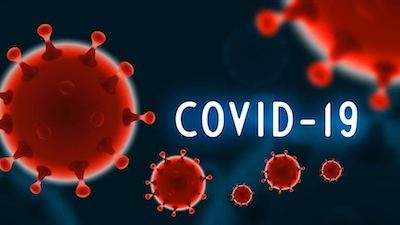

**Project: Detect Coronavirus From CT-Scan image**

**Date: Summer 2022**

**Developers:**


1.   Maedeh Mirzazadeh (@maedemir on [github](https://github.com/maedemir))
2.   Seyed Nami Modarressi (@SNamiMod on [github](https://github.com/SNamiMod))



# Step1: Loading and Visualizing the Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
import cv2
import seaborn as sns
import numpy as np
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_dataset(path):
  dataset = []
  counter = 0
  number_of_data = len(os.listdir(path))
  for dir in sorted(os.listdir(path)):   # ploting first 10 images of the non-covid data
    if counter == 1200:
      break
    imgPath = os.path.join(path, dir) 
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # saving images as RGB
    dataset.append(img)
    counter += 1
  return number_of_data, dataset

In [4]:
def plot_dataset(dataset, num):
  counter = 0
  plt.figure(figsize = (5, 10)) # width = 5 inches and heighty = 10 inches
  for i, img in enumerate(dataset[:num]):
    ax = plt.subplot(5, 2, counter+1)
    plt.title(i+1)
    plt.imshow(img, cmap='gray', aspect = 'auto')
    plt.axis('off')
    counter += 1
  plt.subplots_adjust(hspace = 0.5, wspace = 0.1)  # hspace = vertical distance between images
  plt.show()                                       # wspace = horizental distance between images
  

## Let's see some samples of corona positive dataset

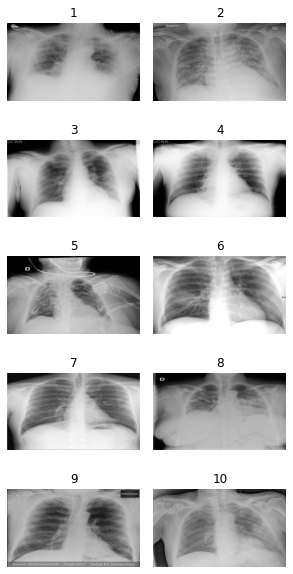

In [5]:
covid_positive_path = '/content/drive/MyDrive/CXR_IMAGES/CXR_COVID' # Path of covid positive folder
cp_num, covid_positive_data = load_dataset(covid_positive_path)
plot_dataset(covid_positive_data, 10)

## and now some examples of corona negative dataset

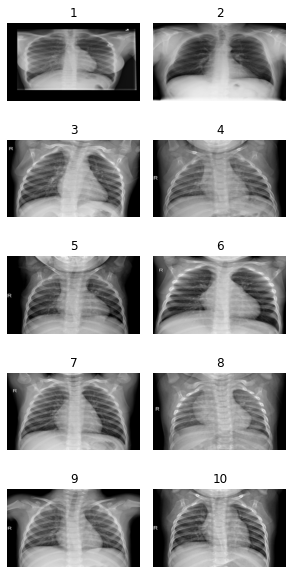

In [6]:
covid_negative_path = '/content/drive/MyDrive/CXR_IMAGES/CXR_NonCOVID' #Path of covid negative folder
cn_num, covid_negative_data = load_dataset(covid_negative_path)
plot_dataset(covid_negative_data, 10)

# Step2: Data Pre-Processing 


1.   Resizing all images
2.   Split data to train(data and label) and test(data and label) --> 80% train , 20% test
3.   Normalization
4.   Data Augmentation

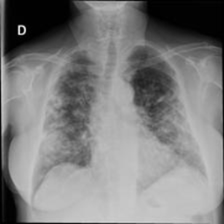

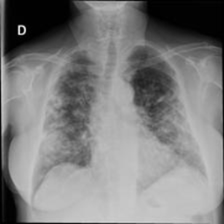

In [8]:
# resizing images
def resize(dataset):
  dim = (224, 224)   # VGG16 takes input tensor size as 224, 244 with 3 RGB channel
  result = []
  for im in dataset:
    result.append(cv2.resize(im, dim))
  return result

from google.colab.patches import cv2_imshow
cv2_imshow(covid_positive_data[10])
covid_positive_data = resize(covid_positive_data)
covid_negative_data = resize(covid_negative_data)
cv2_imshow(covid_positive_data[10])


In [9]:
# Split data to train, test

all_data = covid_positive_data + covid_negative_data

# label for positive corona = 1 , label for negative corona = 0
all_labels = [1] * len(covid_positive_data) + [0] * len(covid_negative_data)

all_data = np.array(all_data)/255

# splitting data to train and test(both labels and data)
x_train, x_test, y_train, y_test = train_test_split(all_data, all_labels, train_size = .8)

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(1920, 224, 224, 3)
(1920, 2)
(480, 224, 224, 3)
(480, 2)


In [10]:
#  Data Augmentation
datagenerator = ImageDataGenerator(rotation_range=20,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   height_shift_range=0.2,  # vertical shift
                                   horizontal_flip=True  # horizontal flip
                                    )

# Step3: Buliding & Training our Model

In [11]:
ResNet50_base_model = tf.keras.applications.ResNet50(weights = 'imagenet',
                                         include_top = False,
                                         input_shape = (224,224,3))
for layer in ResNet50_base_model.layers:
  layer.trainable = False

ResNet50_base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

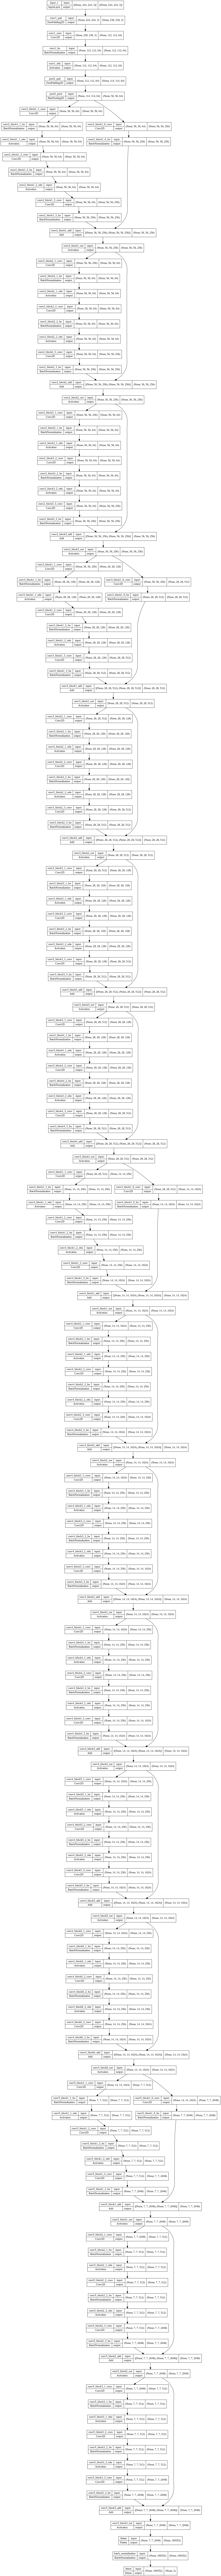

In [12]:
outputs = ResNet50_base_model.output
outputs = Flatten(name = "flatten")(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation="softmax")(outputs)
final_model = Model(inputs = ResNet50_base_model.input, outputs = outputs)

adam =  tf.keras.optimizers.Adam()
final_model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
# Fit
batch_size1 = 32
epochs1 = 20
history = final_model.fit(datagenerator.flow(x_train, y_train, batch_size= batch_size1),
                    validation_data=(x_test, y_test),
                    validation_steps=len(x_test) / batch_size1,
                    steps_per_epoch=len(x_train) / batch_size1,
                    epochs= epochs1)

Epoch 1/20
60/60 [==============================] - 40s 406ms/step - loss: 0.5892 - accuracy: 0.7411 - val_loss: 1.8031 - val_accuracy: 0.4896
Epoch 2/20
60/60 [==============================] - 22s 371ms/step - loss: 0.4814 - accuracy: 0.7781 - val_loss: 2.2843 - val_accuracy: 0.4896
Epoch 3/20
60/60 [==============================] - 22s 367ms/step - loss: 0.4736 - accuracy: 0.7807 - val_loss: 2.1764 - val_accuracy: 0.4896
Epoch 4/20
60/60 [==============================] - 23s 385ms/step - loss: 0.4986 - accuracy: 0.7932 - val_loss: 1.1300 - val_accuracy: 0.4938
Epoch 5/20
60/60 [==============================] - 24s 392ms/step - loss: 0.5090 - accuracy: 0.7859 - val_loss: 0.5815 - val_accuracy: 0.6625
Epoch 6/20
60/60 [==============================] - 22s 368ms/step - loss: 0.4826 - accuracy: 0.7958 - val_loss: 0.6251 - val_accuracy: 0.6292
Epoch 7/20
60/60 [==============================] - 23s 384ms/step - loss: 0.4622 - accuracy: 0.8031 - val_loss: 0.4759 - val_accuracy: 0.7667

# Step4: Save and Evaluate the model

In [14]:
final_model.evaluate(x_test, y_test, batch_size1)

15/15 [==============================] - 1s 95ms/step - loss: 0.5183 - accuracy: 0.8583


[0.5183408856391907, 0.8583333492279053]

In [15]:
# Prediction
y_prediction = final_model.predict(x_test, batch_size=batch_size1)

# Convert to Binary classes
binary_y_test= np.argmax(y_test, axis=1)
binary_y_prediction = np.argmax(y_prediction, axis=1)

# Classification reports
print(classification_report(binary_y_test, binary_y_prediction))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       235
           1       0.85      0.88      0.86       245

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480



In [16]:
final_model.save('/content/drive/MyDrive/CXR_IMAGES/ResNet50_CXR_model.h5')
final_model.save_weights('/content/drive/MyDrive/CXR_IMAGES/ResNet50_CXR_model_wights.h5')

In [17]:
# loading our model
trained_model = load_model('/content/drive/MyDrive/CXR_IMAGES/ResNet50_CXR_model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


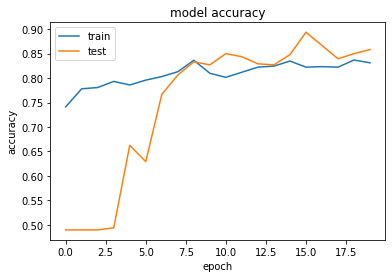

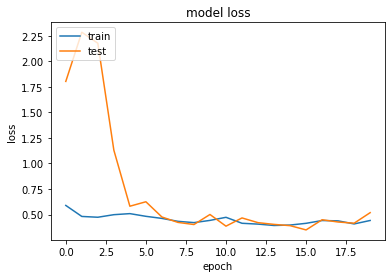

In [18]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

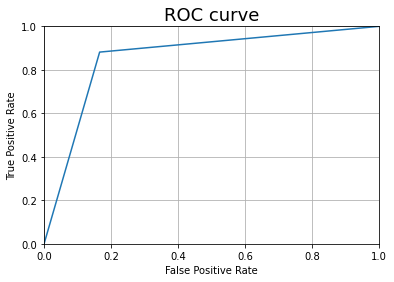

In [19]:
fpr, tpr, thresholds_keras = roc_curve(binary_y_test, binary_y_prediction)
auc_keras = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.rcParams['font.size'] = 15
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.grid(True)

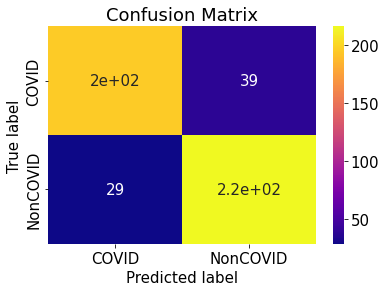

Confusion Matrix without Normalization


In [20]:
classes = ['COVID','NonCOVID']
tick_marks = [0.5,1.5]
confusionMatrix = confusion_matrix(binary_y_test, binary_y_prediction, normalize=None)
sns.heatmap(confusionMatrix, cmap='plasma',annot=True)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print('Confusion Matrix without Normalization')

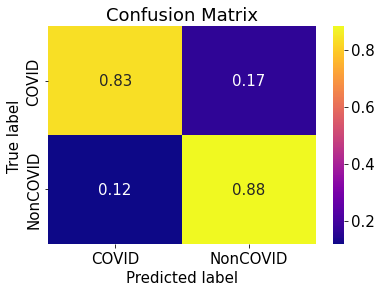

Confusion Matrix with Normalized Values


In [21]:
classes = ['COVID','NonCOVID']
tick_marks = [0.5,1.5]
confusionMatrix = confusion_matrix(binary_y_test, binary_y_prediction, normalize='true')
sns.heatmap(confusionMatrix, cmap='plasma',annot=True)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print('Confusion Matrix with Normalized Values')